In [1]:
import os
import warnings
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
#Loading data and displaying datatypes
df = pd.read_csv("Employee_dataset.csv")
print("Original shape:", df.shape)
print("DataTypes:",df.dtypes)

Original shape: (1470, 35)
DataTypes: Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel 

In [3]:
#Displaying first five rows

print(df.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [4]:
#Numeric summary statistics


num_cols=df.select_dtypes(include=['number']).columns.tolist()
print("Numeric summary statistics:\n",df[num_cols].describe().T)

Numeric summary statistics:
                            count          mean          std     min      25%  \
Age                       1470.0     36.923810     9.135373    18.0    30.00   
DailyRate                 1470.0    802.485714   403.509100   102.0   465.00   
DistanceFromHome          1470.0      9.192517     8.106864     1.0     2.00   
Education                 1470.0      2.912925     1.024165     1.0     2.00   
EmployeeCount             1470.0      1.000000     0.000000     1.0     1.00   
EmployeeNumber            1470.0   1024.865306   602.024335     1.0   491.25   
EnvironmentSatisfaction   1470.0      2.721769     1.093082     1.0     2.00   
HourlyRate                1470.0     65.891156    20.329428    30.0    48.00   
JobInvolvement            1470.0      2.729932     0.711561     1.0     2.00   
JobLevel                  1470.0      2.063946     1.106940     1.0     1.00   
JobSatisfaction           1470.0      2.728571     1.102846     1.0     2.00   
MonthlyInco

In [5]:
print("Missing values in each column:\n",df.isnull().sum())

Missing values in each column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInC

In [5]:
# Show counts of all performance labels, including missing ones
target = 'PerformanceRating'

if target in df.columns:
    # Map numeric ratings to descriptive labels
    rating_map = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
    df['performance_label'] = df[target].map(rating_map)

    # Define all possible labels
    all_labels = ['Low', 'Good', 'Excellent', 'Outstanding']
    
    # Count occurrences (include missing labels with count 0)
    class_counts = df['performance_label'].value_counts().reindex(all_labels, fill_value=0)
    
    # Display neatly
    print("=== Distribution of Performance Classes ===")
    for label, count in class_counts.items():
        print(f"{label:<12}: {count}")
else:
    print(f"Target variable '{target}' not found in dataset.")


=== Distribution of Performance Classes ===
Low         : 0
Good        : 0
Excellent   : 1244
Outstanding : 226



Distribution of Performance Classes:
 performance_label
Excellent      1244
Outstanding     226
Name: count, dtype: int64


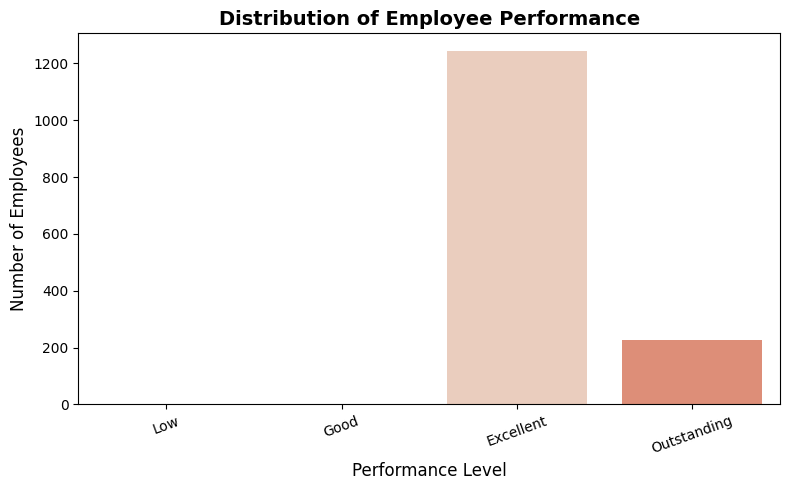

In [8]:
# visualization before SMOTE
target = 'PerformanceRating'

if target in df.columns:
    # Map numeric ratings to descriptive labels (skip missing values)
    rating_map = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
    df['performance_label'] = df[target].map(rating_map)
    
    # Count of each performance class
    class_counts = df['performance_label'].value_counts()
    print("\nDistribution of Performance Classes:\n", class_counts)
    
    # Plotting the distribution using 'coolwarm' palette
    plt.figure(figsize=(8,5))
    sns.countplot(
        x='performance_label', 
        data=df, 
        order=['Low','Good','Excellent','Outstanding'], 
        palette='coolwarm'
    )
    plt.title('Distribution of Employee Performance', fontsize=14, fontweight='bold')
    plt.xlabel('Performance Level', fontsize=12)
    plt.ylabel('Number of Employees', fontsize=12)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"Target variable '{target}' not found in dataset.")


Distribution of Performance Classes:
 performance_label
Excellent      1244
Outstanding     226
Name: count, dtype: int64


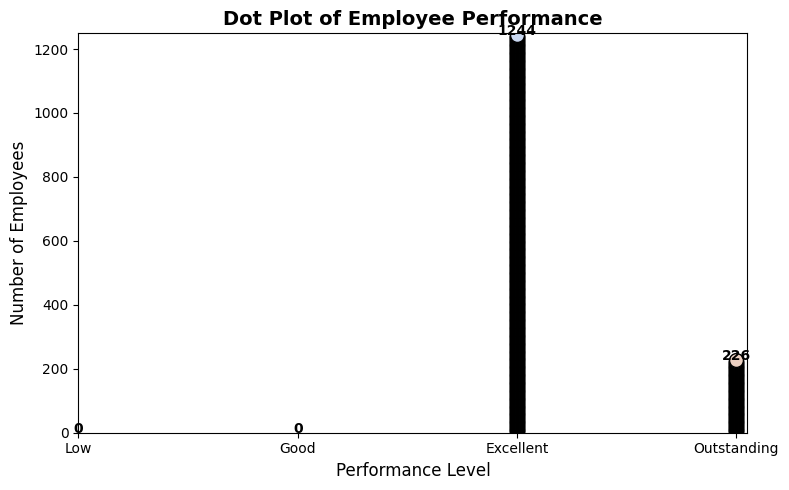

In [9]:
# Target variable
target = 'PerformanceRating'

if target in df.columns:
    # Map numeric ratings to descriptive labels (skip missing values)
    rating_map = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
    df['performance_label'] = df[target].map(rating_map)
    
    # Count of each performance class
    class_counts = df['performance_label'].value_counts()
    print("\nDistribution of Performance Classes:\n", class_counts)
    
    # Create a stacked dot plot (dots stacked vertically)
    plt.figure(figsize=(8,5))
    
    # Loop through each category and plot stacked dots
    for i, label in enumerate(['Low','Good','Excellent','Outstanding']):
        count = class_counts.get(label, 0)
        plt.scatter(
            [i]*count,  # x-coordinate repeated
            list(range(1, count+1)),  # y-coordinate stacked
            s=100,      # dot size
            color=sns.color_palette("coolwarm")[i],
            edgecolor='k'
        )
        # Add count label on top
        plt.text(i, count + 0.5, str(count), ha='center', fontweight='bold')
    
    plt.xticks(range(4), ['Low','Good','Excellent','Outstanding'])
    plt.xlabel('Performance Level', fontsize=12)
    plt.ylabel('Number of Employees', fontsize=12)
    plt.title('Dot Plot of Employee Performance', fontsize=14, fontweight='bold')
    plt.ylim(0, max(class_counts)+5)
    plt.tight_layout()
    plt.show()
else:
    print(f"Target variable '{target}' not found in dataset.")

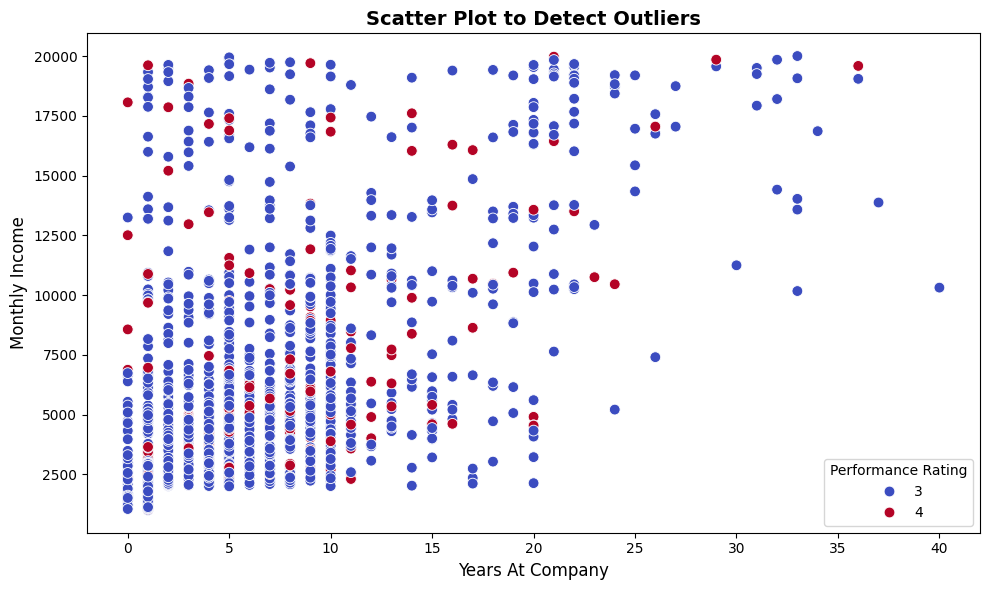

In [10]:
# Scatter plot to check for outliers
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='YearsAtCompany',  # choose one numeric column for x-axis
    y='MonthlyIncome',   # choose one numeric column for y-axis
    hue='PerformanceRating',  # color by performance (optional)
    data=df,
    palette='coolwarm',
    s=60  # size of points
)
plt.title('Scatter Plot to Detect Outliers', fontsize=14, fontweight='bold')
plt.xlabel('Years At Company', fontsize=12)
plt.ylabel('Monthly Income', fontsize=12)
plt.legend(title='Performance Rating')
plt.tight_layout()
plt.show()

In [6]:
# Drop the given unnecessary columns
drop_cols = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours", 
             "DailyRate", "HourlyRate", "MonthlyRate"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("After dropping columns:", df.shape)

After dropping columns: (1470, 29)


In [7]:
# Step 2 - Add synthetic samples (your code)
# ------------------------------
n_samples_low =2150
n_samples_good = 2200
n_samples_excellent = 960
n_samples_outstanding = 1964

low_samples = df.sample(n=n_samples_low, replace=True).copy()
good_samples = df.sample(n=n_samples_good, replace=True).copy()
excellent_samples = df.sample(n=n_samples_excellent, replace=True).copy()
outstanding_samples = df.sample(n=n_samples_outstanding, replace=True).copy()

# Low (1)
low_samples["PerformanceRating"] = 1
low_samples["JobSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["WorkLifeBalance"] = np.random.randint(1, 3, n_samples_low)
low_samples["EnvironmentSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["RelationshipSatisfaction"] = np.random.randint(1, 3, n_samples_low)
low_samples["JobInvolvement"] = np.random.randint(1, 3, n_samples_low)

# Good (2)
good_samples["PerformanceRating"] = 2
good_samples["JobSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["WorkLifeBalance"] = np.random.randint(2, 4, n_samples_good)
good_samples["EnvironmentSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["RelationshipSatisfaction"] = np.random.randint(2, 4, n_samples_good)
good_samples["JobInvolvement"] = np.random.randint(2, 4, n_samples_good)

# Excellent (3)
excellent_samples["PerformanceRating"] = 3
excellent_samples["JobSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["WorkLifeBalance"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["EnvironmentSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["RelationshipSatisfaction"] = np.random.randint(3, 5, n_samples_excellent)
excellent_samples["JobInvolvement"] = np.random.randint(3, 5, n_samples_excellent)

# Outstanding (4)
outstanding_samples["PerformanceRating"] = 4
outstanding_samples["JobSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["WorkLifeBalance"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["EnvironmentSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["RelationshipSatisfaction"] = np.random.randint(4, 5, n_samples_outstanding)
outstanding_samples["JobInvolvement"] = np.random.randint(4, 5, n_samples_outstanding)

# Combine + shuffle
df_augmented = pd.concat([df, low_samples, good_samples, excellent_samples, outstanding_samples], ignore_index=True)
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)
print("Augmented dataset shape:", df_augmented.shape)
print("PerformanceRating distribution:\n", df_augmented["PerformanceRating"].value_counts())


Augmented dataset shape: (8744, 29)
PerformanceRating distribution:
 PerformanceRating
3    2204
2    2200
4    2190
1    2150
Name: count, dtype: int64


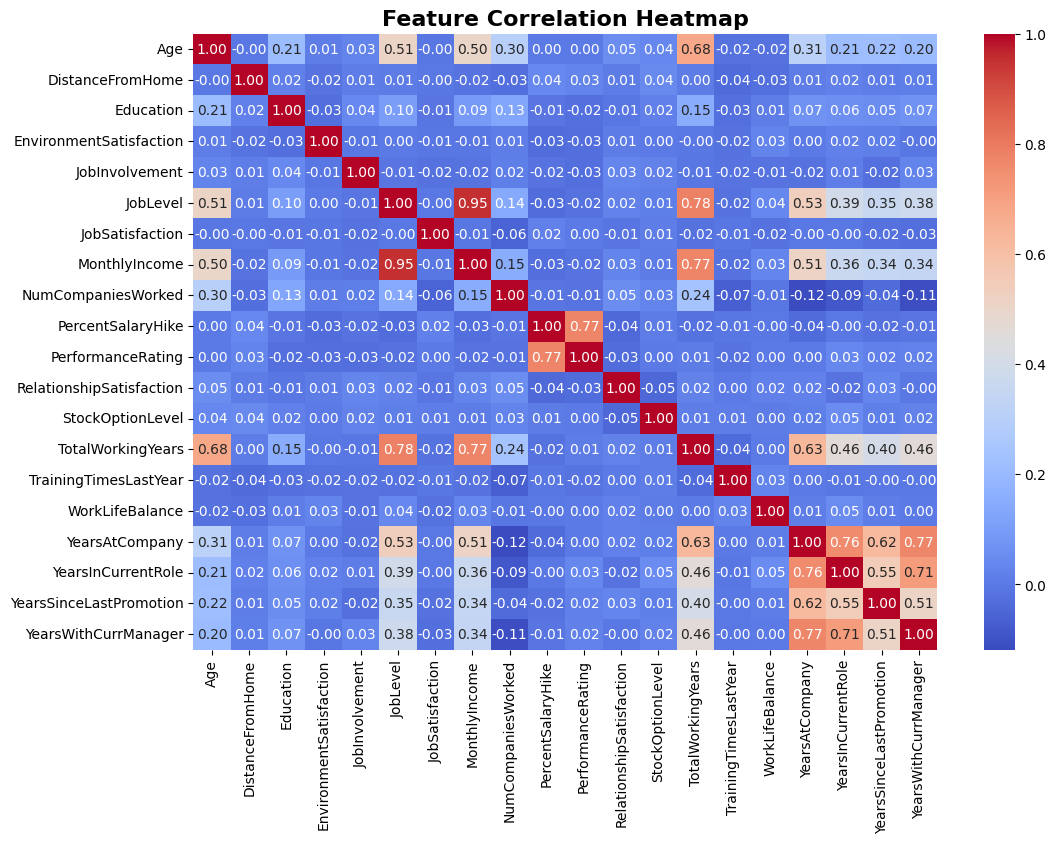

In [14]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation
corr_matrix = numeric_df.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()


In [8]:
import pandas as pd

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Print correlation matrix
print("=== Correlation Matrix ===")
print(corr_matrix)

# Optional: print correlation of each feature with the target
target = 'PerformanceRating'  # replace with your target column
if target in corr_matrix.columns:
    print("\n=== Correlation with Target ===")
    print(corr_matrix[target].sort_values(ascending=False))


=== Correlation Matrix ===
                               Age  DistanceFromHome  Education  \
Age                       1.000000         -0.001686   0.208034   
DistanceFromHome         -0.001686          1.000000   0.021042   
Education                 0.208034          0.021042   1.000000   
EnvironmentSatisfaction   0.010146         -0.016075  -0.027128   
JobInvolvement            0.029820          0.008783   0.042438   
JobLevel                  0.509604          0.005303   0.101589   
JobSatisfaction          -0.004892         -0.003669  -0.011296   
MonthlyIncome             0.497855         -0.017014   0.094961   
NumCompaniesWorked        0.299635         -0.029251   0.126317   
PercentSalaryHike         0.003634          0.040235  -0.011111   
PerformanceRating         0.001904          0.027110  -0.024539   
RelationshipSatisfaction  0.053535          0.006557  -0.009118   
StockOptionLevel          0.037510          0.044872   0.018422   
TotalWorkingYears         0.680381 

In [9]:
X = df_augmented.drop(["PerformanceRating"], axis=1)
y = df_augmented["PerformanceRating"]

# Identify categorical columns and encode with LabelEncoder (save encoders)
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Feature shape:", X.shape)
# Save the encoders and feature column order (so you can reuse exactly the same preprocess later)
joblib.dump(encoders, "label_encoders.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")
print("Saved label_encoders.pkl and feature_columns.pkl")


Feature shape: (8744, 28)
Saved label_encoders.pkl and feature_columns.pkl


In [20]:
print("Dataset shape(row,column):", X.shape)

Dataset shape(row,column): (8744, 28)


In [10]:
# Step 4 - Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (6995, 28) X_test shape: (1749, 28)


In [11]:
# S - Apply SMOTE (or load saved SMOTE file if exists)
# ------------------------------
SMOTE_FILE = "smote_dataset.csv"

if os.path.exists(SMOTE_FILE):
    print(f"Found {SMOTE_FILE} — loading instead of re-running SMOTE.")
    df_smote = pd.read_csv(SMOTE_FILE)
    X_train_res = df_smote.drop(columns=["PerformanceRating"])
    y_train_res = df_smote["PerformanceRating"]
else:
    print("Running SMOTE to balance training set (this may take a moment)...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
   
    smote_resampled = pd.DataFrame(X_train_res, columns=X_train.columns)
    smote_resampled["PerformanceRating"] = y_train_res
    smote_resampled.to_csv(SMOTE_FILE, index=False)
    print("SMOTE resampled dataset saved to", SMOTE_FILE)

print("After SMOTE, training shape:", X_train_res.shape, y_train_res.value_counts().to_dict())


Found smote_dataset.csv — loading instead of re-running SMOTE.
After SMOTE, training shape: (7052, 27) {1: 1763, 3: 1763, 2: 1763, 4: 1763}


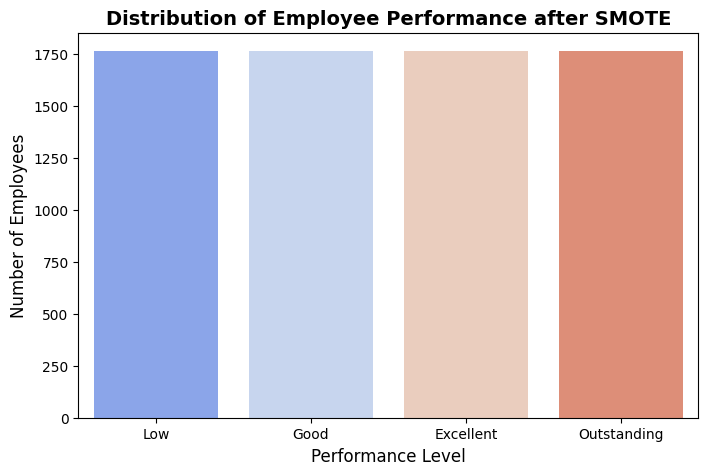

Counts after SMOTE:
 PerformanceLabel
Low            1763
Excellent      1763
Good           1763
Outstanding    1763
Name: count, dtype: int64


In [14]:
# Combine into a single DataFrame for visualization
df_smote = pd.DataFrame(X_train_res, columns=X_train.columns)
df_smote['PerformanceRating'] = y_train_res

# Optional: Map numeric ratings to labels
rating_map = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
df_smote['PerformanceLabel'] = df_smote['PerformanceRating'].map(rating_map)

# Plot bar chart
plt.figure(figsize=(8,5))
sns.countplot(
    x='PerformanceLabel', 
    data=df_smote,
    order=['Low','Good','Excellent','Outstanding'],
    palette='coolwarm'
)
plt.title('Distribution of Employee Performance after SMOTE', fontsize=14, fontweight='bold')
plt.xlabel('Performance Level', fontsize=12)
plt.ylabel('Number of Employees', fontsize=12)
plt.show()

# Optional: Print counts
print("Counts after SMOTE:\n", df_smote['PerformanceLabel'].value_counts())


Distribution of Performance Classes after SMOTE:
 PerformanceLabel
Low            1763
Excellent      1763
Good           1763
Outstanding    1763
Name: count, dtype: int64


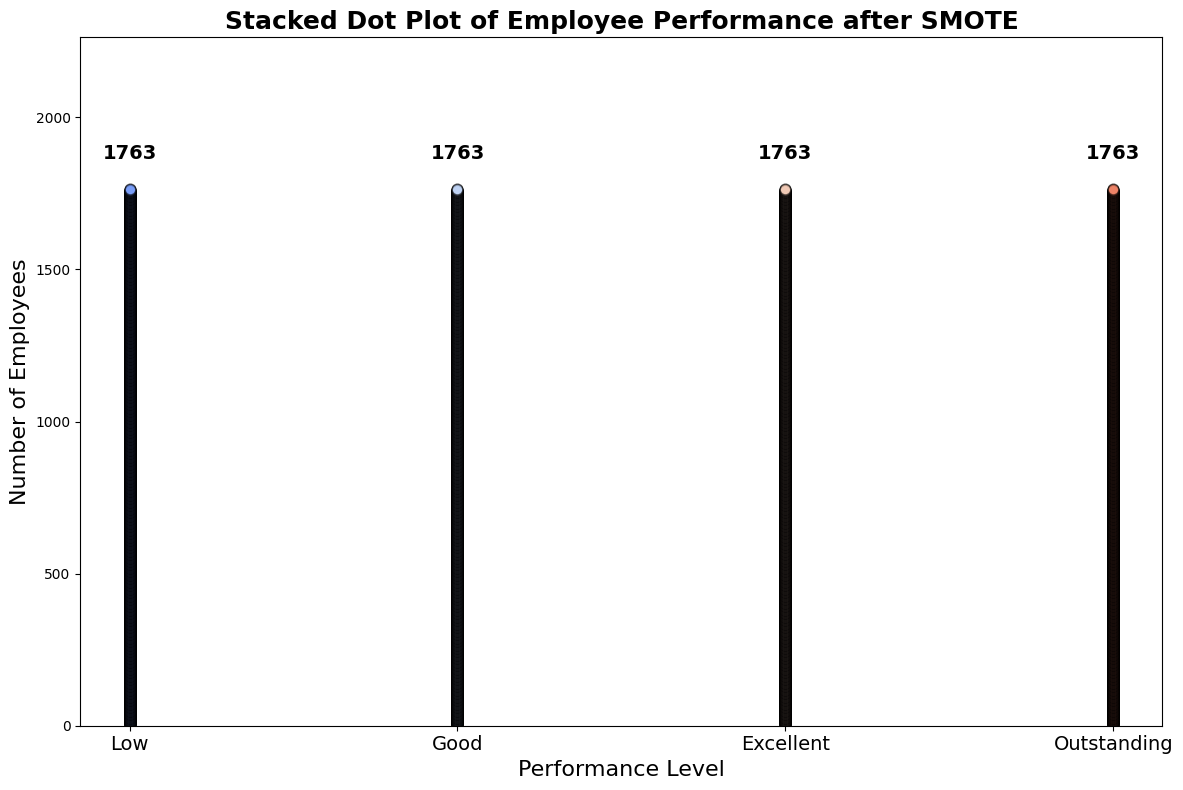

In [15]:
# Map numeric PerformanceRating to descriptive labels
rating_map = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
df_smote['PerformanceLabel'] = df_smote['PerformanceRating'].map(rating_map)

# Count of each performance class
class_counts = df_smote['PerformanceLabel'].value_counts()
print("\nDistribution of Performance Classes after SMOTE:\n", class_counts)

# Create stacked dot plot
plt.figure(figsize=(12,8))
colors = sns.color_palette("coolwarm", 4)

for i, label in enumerate(['Low','Good','Excellent','Outstanding']):
    count = class_counts.get(label, 0)
    # Stack dots vertically
    plt.scatter(
        [i]*count,
        list(range(1, count+1)),
        s=60,            # dot size
        color=colors[i],
        edgecolor='k',
        alpha=0.6        # semi-transparent for large datasets
    )
    # Add count label on top
    plt.text(i, count + 100, str(count), ha='center', fontweight='bold', fontsize=14)

plt.xticks(range(4), ['Low','Good','Excellent','Outstanding'], fontsize=14)
plt.xlabel('Performance Level', fontsize=16)
plt.ylabel('Number of Employees', fontsize=16)
plt.title('Stacked Dot Plot of Employee Performance after SMOTE', fontsize=18, fontweight='bold')
plt.ylim(0, max(class_counts)+500)  # leave space for labels
plt.tight_layout()
plt.show()

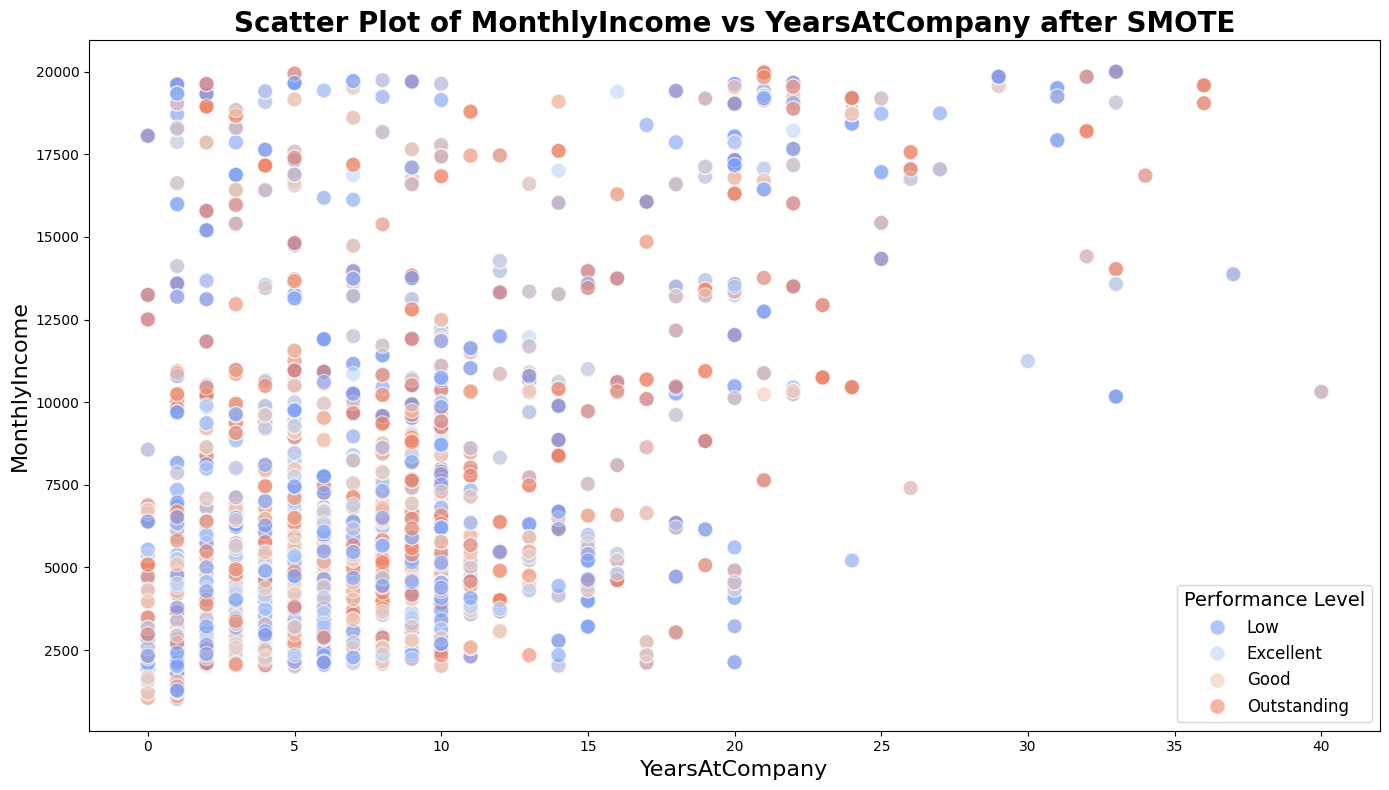

In [16]:
# Choose two numeric columns to visualize
x_col = 'YearsAtCompany'   # example numeric feature
y_col = 'MonthlyIncome'    # example numeric feature

plt.figure(figsize=(14,8))  # larger figure for clarity
sns.scatterplot(
    x=x_col,
    y=y_col,
    hue='PerformanceLabel',
    data=df_smote,
    palette='coolwarm',
    s=120,        # point size for visibility
    alpha=0.6     # semi-transparent for overlapping points
)

# Titles and labels
plt.title(f'Scatter Plot of {y_col} vs {x_col} after SMOTE', fontsize=20, fontweight='bold')
plt.xlabel(x_col, fontsize=16)
plt.ylabel(y_col, fontsize=16)
plt.legend(title='Performance Level', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


=== Random Forest Results ===
Accuracy: 0.9531160663236135
Classification Report:
               precision    recall  f1-score   support

           1       0.97      1.00      0.98       430
           2       0.92      0.97      0.94       440
           3       0.95      0.90      0.92       441
           4       0.98      0.94      0.96       438

    accuracy                           0.95      1749
   macro avg       0.95      0.95      0.95      1749
weighted avg       0.95      0.95      0.95      1749



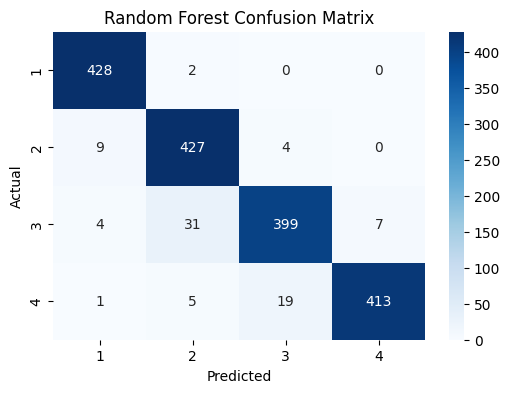

In [12]:
# Step 6 - Train Random Forest
# ------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

# Fix X_test to have exactly the same columns as X_train_res
X_test_corrected = X_test[X_train_res.columns]  # <-- Add this line

# Now predict
y_pred_rf = rf.predict(X_test_corrected)
print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[1,2,3,4])
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== XGBoost Results ===
XGBoost Accuracy: 0.9605488850771869
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       430
           2       0.91      0.97      0.94       440
           3       0.97      0.91      0.94       441
           4       0.98      0.98      0.98       438

    accuracy                           0.96      1749
   macro avg       0.96      0.96      0.96      1749
weighted avg       0.96      0.96      0.96      1749



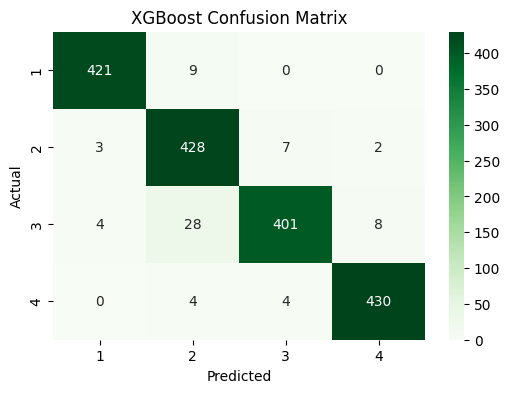

In [13]:
# Step 7 - Train XGBoost 
# ------------------------------
y_train_res_xgb = y_train_res - 1  
y_test_xgb = y_test - 1            

xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train_res, y_train_res_xgb)

# Fix X_test to match X_train_res columns
X_test_corrected = X_test[X_train_res.columns]  # <-- Align columns

# Predict
y_pred_xgb = xgb.predict(X_test_corrected)              
y_pred_xgb_orig = y_pred_xgb + 1              

# Evaluate
xgb_acc = accuracy_score(y_test, y_pred_xgb_orig)
print("\n=== XGBoost Results ===")
print("XGBoost Accuracy:", xgb_acc)
print(classification_report(y_test, y_pred_xgb_orig, labels=[1,2,3,4], zero_division=0))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_orig, labels=[1,2,3,4])
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


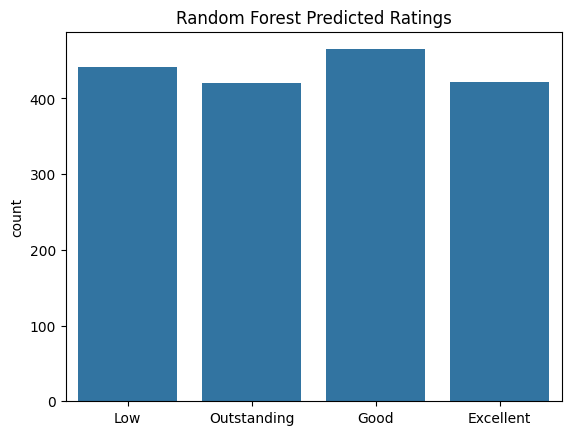

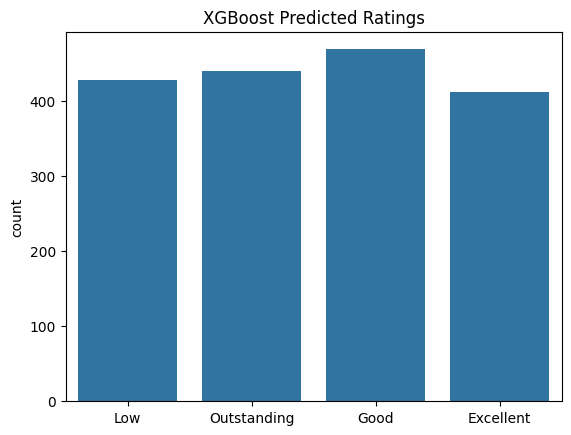

In [19]:
# Step 8 - Quick prediction distribution plots (readable labels)
# ------------------------------
rating_map = {1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}
y_pred_rf_labels = [rating_map[i] for i in y_pred_rf]
y_pred_xgb_labels = [rating_map[i] for i in y_pred_xgb_orig]

plt.figure()
sns.countplot(x=y_pred_rf_labels)
plt.title("Random Forest Predicted Ratings")
plt.show()

plt.figure()
sns.countplot(x=y_pred_xgb_labels)
plt.title("XGBoost Predicted Ratings")
plt.show()


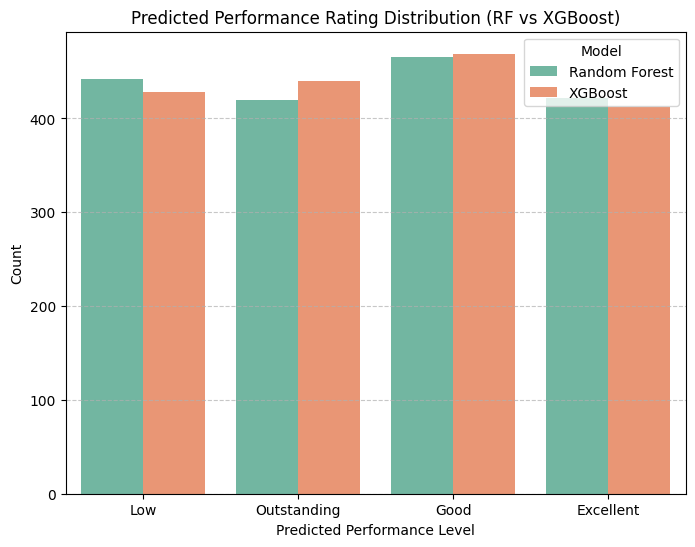

In [20]:
# Step 8 - Combined prediction distribution plot
# ----------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Map numeric predictions to readable labels
rating_map = {1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}
y_pred_rf_labels = [rating_map[i] for i in y_pred_rf]
y_pred_xgb_labels = [rating_map[i] for i in y_pred_xgb_orig]

# Create DataFrame for plotting
combined_df = pd.DataFrame({
    'Prediction': y_pred_rf_labels + y_pred_xgb_labels,
    'Model': (['Random Forest'] * len(y_pred_rf_labels)) + (['XGBoost'] * len(y_pred_xgb_labels))
})

# Plot both in one chart
plt.figure(figsize=(8,6))
sns.countplot(data=combined_df, x='Prediction', hue='Model', palette='Set2')
plt.title("Predicted Performance Rating Distribution (RF vs XGBoost)")
plt.xlabel("Predicted Performance Level")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
# Step 9 - Model comparison metrics table
# ------------------------------
rf_prec = precision_score(y_test, y_pred_rf, average=None, labels=[1,2,3,4], zero_division=0)
rf_rec  = recall_score(y_test, y_pred_rf,  average=None, labels=[1,2,3,4], zero_division=0)
rf_f1   = f1_score(y_test, y_pred_rf,      average=None, labels=[1,2,3,4], zero_division=0)
rf_acc  = accuracy_score(y_test, y_pred_rf)

xgb_prec = precision_score(y_test, y_pred_xgb_orig, average=None, labels=[1,2,3,4], zero_division=0)
xgb_rec  = recall_score(y_test, y_pred_xgb_orig,  average=None, labels=[1,2,3,4], zero_division=0)
xgb_f1   = f1_score(y_test, y_pred_xgb_orig,      average=None, labels=[1,2,3,4], zero_division=0)
xgb_acc  = accuracy_score(y_test, y_pred_xgb_orig)

ratings = ["Low", "Good", "Excellent", "Outstanding"]

comparison_clean = pd.DataFrame({
    "Rating": ratings + ["Overall Accuracy"],
    "Random Forest (Precision)": list(rf_prec) + [rf_acc],
    "Random Forest (Recall)": list(rf_rec) + [rf_acc],
    "Random Forest (F1-score)": list(rf_f1) + [rf_acc],
    "XGBoost (Precision)": list(xgb_prec) + [xgb_acc],
    "XGBoost (Recall)": list(xgb_rec) + [xgb_acc],
    "XGBoost (F1-score)": list(xgb_f1) + [xgb_acc]
})

print("\n=== Model comparison ===")
print(comparison_clean)



=== Model comparison ===
             Rating  Random Forest (Precision)  Random Forest (Recall)  \
0               Low                   0.968326                0.995349   
1              Good                   0.918280                0.970455   
2         Excellent                   0.945498                0.904762   
3       Outstanding                   0.983333                0.942922   
4  Overall Accuracy                   0.953116                0.953116   

   Random Forest (F1-score)  XGBoost (Precision)  XGBoost (Recall)  \
0                  0.981651             0.983645          0.979070   
1                  0.943646             0.912580          0.972727   
2                  0.924681             0.973301          0.909297   
3                  0.962704             0.977273          0.981735   
4                  0.953116             0.960549          0.960549   

   XGBoost (F1-score)  
0            0.981352  
1            0.941694  
2            0.940211  
3           

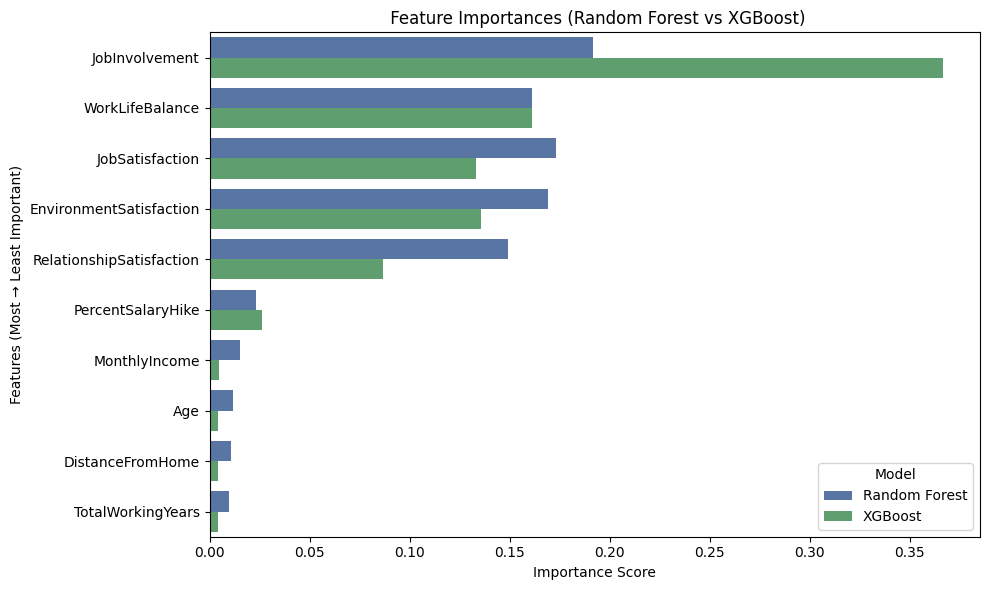

In [15]:
# Step 10 - Top 10 Combined Feature Importances (RF vs XGBoost)
# --------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get individual importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train_res.columns, name='Random Forest')
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train_res.columns, name='XGBoost')

# Compute average importance
avg_importance = (rf_importances + xgb_importances) / 2

# Select top 10 features based on average importance
top_features = avg_importance.sort_values(ascending=False).head(10).index

# Prepare DataFrame for plotting
imp_df = pd.DataFrame({
    'Feature': X_train_res.columns,
    'Random Forest': rf_importances.values,
    'XGBoost': xgb_importances.values
}).melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Keep only top 10 features
imp_df = imp_df[imp_df['Feature'].isin(top_features)]

# Reorder features for display
imp_df['Feature'] = pd.Categorical(
    imp_df['Feature'], 
    categories=top_features, 
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=imp_df,
    x='Importance',
    y='Feature',
    hue='Model',
    palette={'Random Forest': '#4C72B0', 'XGBoost': '#55A868'}  # blue & green
)
plt.title(" Feature Importances (Random Forest vs XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features (Most → Least Important)")
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [16]:
# Step 10 - Feature Importance Report
# -----------------------------------
import pandas as pd

# Get feature importance values
rf_importances = pd.Series(rf.feature_importances_, index=X_train_res.columns)
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train_res.columns)

# Sort and get top 10
rf_top10 = rf_importances.sort_values(ascending=False).head(10)
xgb_top10 = xgb_importances.sort_values(ascending=False).head(10)

# Create DataFrame
feature_report = pd.DataFrame({
    'Random Forest Importance': rf_top10,
    'XGBoost Importance': xgb_top10
})

# Align both for display
feature_report = feature_report.fillna(0)

# Display neatly
print("\n===  Feature Importance  ===\n")
print(feature_report.round(4))

# Optional: save to CSV for report
feature_report.to_csv("feature_importance_report.csv", index_label='Feature')
print("\nReport saved as 'feature_importance_report.csv'")



===  Feature Importance  ===

                          Random Forest Importance  XGBoost Importance
Age                                         0.0118              0.0000
DistanceFromHome                            0.0108              0.0000
EducationField                              0.0000              0.0047
EnvironmentSatisfaction                     0.1690              0.1359
JobInvolvement                              0.1916              0.3669
JobSatisfaction                             0.1733              0.1330
MonthlyIncome                               0.0150              0.0048
OverTime                                    0.0000              0.0052
PercentSalaryHike                           0.0233              0.0264
RelationshipSatisfaction                    0.1494              0.0866
TotalWorkingYears                           0.0096              0.0000
WorkLifeBalance                             0.1614              0.1614
YearsSinceLastPromotion                     0.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Adjust labels for XGBoost (shift by -1)
y_train_res_xgb = y_train_res - 1
y_test_xgb = y_test - 1

# Align test set columns
X_test_aligned = X_test[X_train_res.columns]

# ------------------------------
# Base Random Forest
# ------------------------------
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_res, y_train_res)

# Training accuracy
y_train_pred_rf = rf_base.predict(X_train_res)
train_acc_rf = accuracy_score(y_train_res, y_train_pred_rf)

# Testing accuracy
y_test_pred_rf = rf_base.predict(X_test_aligned)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("Random Forest Training Accuracy:", train_acc_rf)
print("Random Forest Testing Accuracy:", test_acc_rf)

# ------------------------------
# Base XGBoost
# ------------------------------
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_base.fit(X_train_res, y_train_res_xgb)

# Training accuracy
y_train_pred_xgb = xgb_base.predict(X_train_res)
train_acc_xgb = accuracy_score(y_train_res_xgb, y_train_pred_xgb)

# Testing accuracy
y_test_pred_xgb = xgb_base.predict(X_test_aligned)
test_acc_xgb = accuracy_score(y_test_xgb, y_test_pred_xgb)

print("XGBoost Training Accuracy:", train_acc_xgb)
print("XGBoost Testing Accuracy:", test_acc_xgb)


Random Forest Training Accuracy: 0.9968803176403858
Random Forest Testing Accuracy: 0.9531160663236135
XGBoost Training Accuracy: 0.996596710153148
XGBoost Testing Accuracy: 0.9605488850771869


In [18]:
# Step 11 - Hyperparameter tuning (GridSearch for RF and XGB)
# ------------------------------
print("\nRunning GridSearch for Random Forest (this may take a while)...")
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_, "Best RF CV accuracy:", rf_grid.best_score_)

print("\nRunning GridSearch for XGBoost (this may take a while)...")
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
                        xgb_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_res, y_train_res - 1)   
best_xgb = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_, "Best XGB CV accuracy:", xgb_grid.best_score_)



Running GridSearch for Random Forest (this may take a while)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} Best RF CV accuracy: 0.94739066822327

Running GridSearch for XGBoost (this may take a while)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1} Best XGB CV accuracy: 0.9611456721298618


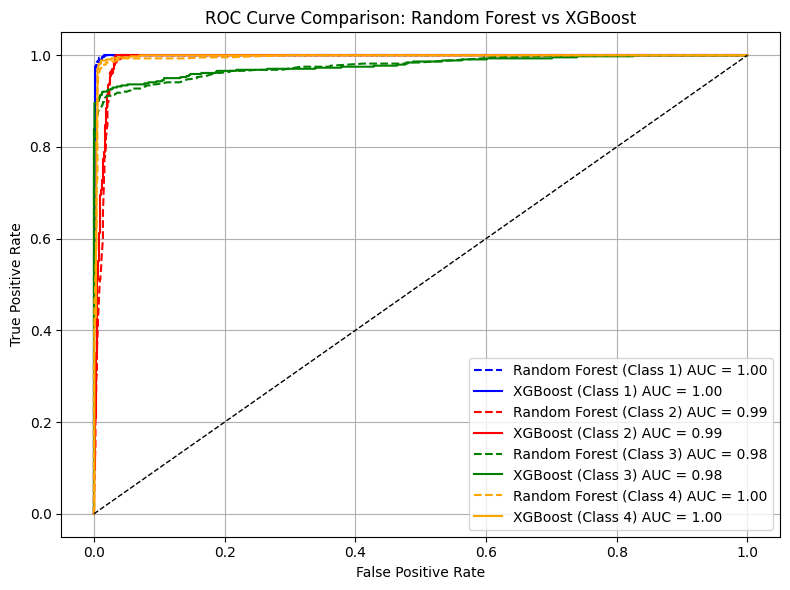

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize the output (for multi-class ROC)
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score_rf = rf_base.predict_proba(X_test_aligned)
y_score_xgb = xgb_base.predict_proba(X_test_aligned)

# Compute ROC curve and AUC for each class
fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}
fpr_xgb, tpr_xgb, roc_auc_xgb = {}, {}, {}

for i, cls in enumerate(classes):
    fpr_rf[cls], tpr_rf[cls], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[cls] = auc(fpr_rf[cls], tpr_rf[cls])

    fpr_xgb[cls], tpr_xgb[cls], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc_xgb[cls] = auc(fpr_xgb[cls], tpr_xgb[cls])

# Plot ROC curve for both models
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(classes, colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, linestyle='--',
             label=f"Random Forest (Class {i}) AUC = {roc_auc_rf[i]:.2f}")
    plt.plot(fpr_xgb[i], tpr_xgb[i], color=color,
             label=f"XGBoost (Class {i}) AUC = {roc_auc_xgb[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# -----------------------------
# Example: raw input for 5 employees
# -----------------------------
raw_input = pd.DataFrame({
    'EnvironmentSatisfaction': [3, 2, 4, 3, 1],
    'JobSatisfaction': [4, 3, 3, 4, 2],
    'OverTime': ['No', 'Yes', 'No', 'Yes', 'No'],
    'PercentSalaryHike': [14, 20, 13, 18, 12],
    'RelationshipSatisfaction': [3, 4, 2, 3, 3],
    'TotalWorkingYears': [5, 12, 7, 15, 3],
    'Department': ['Sales', 'R&D', 'R&D', 'HR', 'Sales'],
    'JobRole': ['Manager', 'Research Scientist', 'Laboratory Technician', 'HR Executive', 'Sales Executive'],
    'YearsWithCurrManager': [2, 5, 3, 6, 1],
    'WorkLifeBalance': [3, 2, 3, 2, 4],
    'TrainingTimesLastYear': [2, 4, 3, 1, 2],
    'JobLevel': [2, 3, 2, 4, 1],
    'JobInvolvement': [3, 4, 2, 3, 4],
    'YearsAtCurrentRole': [3, 7, 5, 10, 2],
    'MonthlyIncome': [4500, 7000, 5200, 8000, 4000]
})

# -----------------------------
# Encode categorical features
# -----------------------------
categorical_features = ['OverTime', 'Department', 'JobRole']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_cats = pd.DataFrame(
    encoder.fit(X_train_res[categorical_features]).transform(raw_input[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features)
)

# Combine encoded features with numerical ones
real_input_encoded = pd.concat([raw_input.drop(columns=categorical_features), encoded_cats], axis=1)

# Align columns with training set
real_input_encoded = real_input_encoded.reindex(columns=X_train_res.columns, fill_value=0)

# -----------------------------
# Predictions
# -----------------------------
# Random Forest
rf_pred_numeric = rf.predict(real_input_encoded)
rf_pred_prob_all = rf.predict_proba(real_input_encoded)  # Probabilities for all classes
rf_pred_prob_max = rf_pred_prob_all.max(axis=1)  # Max confidence
rf_pred_labels = [rating_map[i] for i in rf_pred_numeric]

# XGBoost
xgb_pred_numeric = xgb.predict(real_input_encoded)
xgb_pred_prob_all = xgb.predict_proba(real_input_encoded)  # Probabilities for all classes
xgb_pred_prob_max = xgb_pred_prob_all.max(axis=1)
xgb_pred_labels = [rating_map[i] for i in xgb_pred_numeric]

# -----------------------------
# Print predictions in a clear format
# -----------------------------
for i in range(len(raw_input)):
    input_vals = raw_input.iloc[i].tolist()
    print(f"Input {i+1}: {input_vals}")
    print(f"  → RF: {rf_pred_labels[i]} ({rf_pred_prob_max[i]:.2f}) | Class probabilities: {np.round(rf_pred_prob_all[i],2)}")
    print(f"  → XGB: {xgb_pred_labels[i]} ({xgb_pred_prob_max[i]:.2f}) | Class probabilities: {np.round(xgb_pred_prob_all[i],2)}\n")


Input 1: [np.int64(3), np.int64(4), 'No', np.int64(14), np.int64(3), np.int64(5), 'Sales', 'Manager', np.int64(2), np.int64(3), np.int64(2), np.int64(2), np.int64(3), np.int64(3), np.int64(4500)]
  → RF: Excellent (0.85) | Class probabilities: [0.   0.13 0.85 0.02]
  → XGB: Good (1.00) | Class probabilities: [0. 0. 1. 0.]

Input 2: [np.int64(2), np.int64(3), 'Yes', np.int64(20), np.int64(4), np.int64(12), 'R&D', 'Research Scientist', np.int64(5), np.int64(2), np.int64(4), np.int64(3), np.int64(4), np.int64(7), np.int64(7000)]
  → RF: Excellent (0.64) | Class probabilities: [0.03 0.1  0.64 0.23]
  → XGB: Excellent (0.94) | Class probabilities: [0.   0.01 0.05 0.94]

Input 3: [np.int64(4), np.int64(3), 'No', np.int64(13), np.int64(2), np.int64(7), 'R&D', 'Laboratory Technician', np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(5), np.int64(5200)]
  → RF: Excellent (0.72) | Class probabilities: [0.01 0.19 0.72 0.08]
  → XGB: Good (0.95) | Class probabilities: [0. 

In [40]:
# Step 12 - Evaluate tuned models on test
# ------------------------------

# Align test set columns to match training features
X_test_corrected = X_test[X_train_res.columns]  # Use the same columns as used in training

# Random Forest
rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_corrected))

# XGBoost
xgb_test_preds = best_xgb.predict(X_test_corrected) + 1   
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

print("\nRandom Forest Test Accuracy:", rf_test_acc)
print("XGBoost Test Accuracy:", xgb_test_acc)

# Choose final model
if rf_test_acc >= xgb_test_acc:
    final_model = best_rf
    final_name = "Random Forest"
    needs_label_shift = False
else:
    final_model = best_xgb
    final_name = "XGBoost"
    needs_label_shift = True   

print(f"\n✅ Final Best Model Selected: {final_name}")
final_acc = max(rf_test_acc, xgb_test_acc)
print(f"Accuracy on Test Data: {final_acc:.4f}")



Random Forest Test Accuracy: 0.956546598056032
XGBoost Test Accuracy: 0.9702687249857062

✅ Final Best Model Selected: XGBoost
Accuracy on Test Data: 0.9703


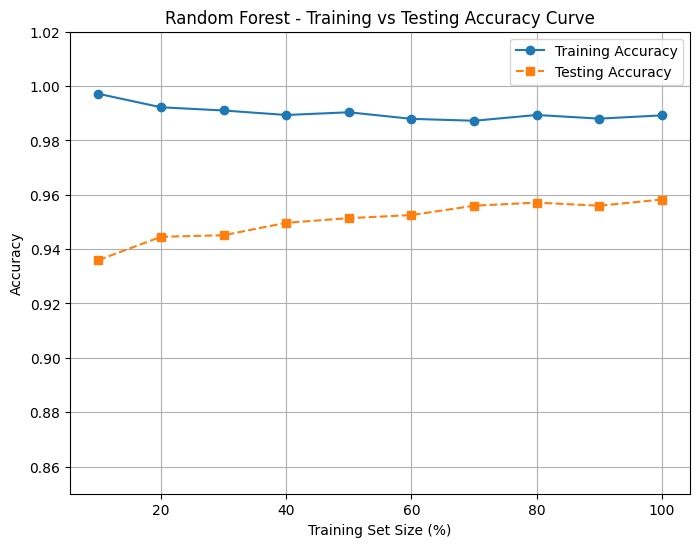

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

# Shuffle training data to ensure randomness
X_shuf, y_shuf = shuffle(X_train_res, y_train_res, random_state=42)

# If you used GridSearchCV, use best_rf; else use your trained RF model
try:
    rf_base = best_rf
except NameError:
    rf_base = RandomForestClassifier(random_state=42)

train_fracs = np.linspace(0.1, 1.0, 10)
rf_train_acc, rf_test_acc = [], []

# Align X_test columns to training features
X_test_corrected = X_test[X_train_res.columns]  # <-- Add this

for frac in train_fracs:
    n = int(len(X_shuf) * frac)
    X_part = X_shuf[:n]
    y_part = y_shuf[:n]

    # Clone to retrain on smaller subsets
    rf_temp = clone(rf_base)
    rf_temp.fit(X_part, y_part)

    # Calculate accuracy
    train_acc = accuracy_score(y_part, rf_temp.predict(X_part))
    test_acc = accuracy_score(y_test, rf_temp.predict(X_test_corrected))  # <-- Use corrected X_test

    rf_train_acc.append(train_acc)
    rf_test_acc.append(test_acc)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_fracs * 100, rf_train_acc, marker='o', label='Training Accuracy')
plt.plot(train_fracs * 100, rf_test_acc, marker='s', linestyle='--', label='Testing Accuracy')
plt.title("Random Forest - Training vs Testing Accuracy Curve")
plt.xlabel("Training Set Size (%)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.02)
plt.grid(True)
plt.legend()
plt.show()


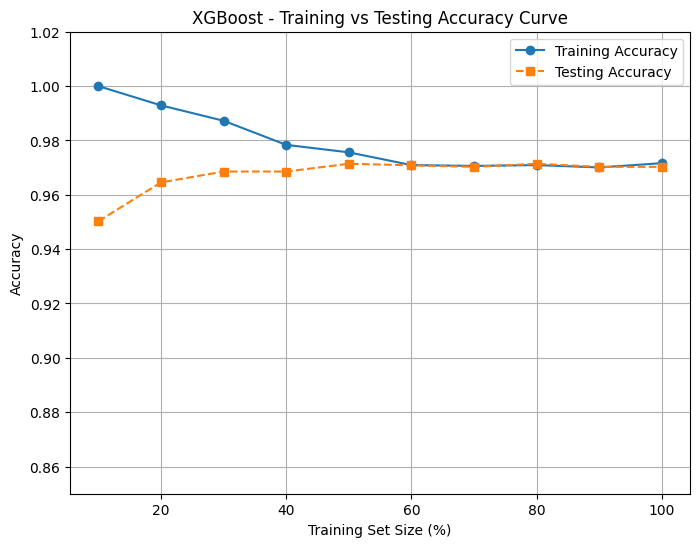

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.base import clone
from xgboost import XGBClassifier

# Shuffle data
X_shuf, y_shuf = shuffle(X_train_res, y_train_res, random_state=42)

# Use tuned model if available
try:
    xgb_base = best_xgb
except NameError:
    xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

train_fracs = np.linspace(0.1, 1.0, 10)
xgb_train_acc, xgb_test_acc = [], []

# Align X_test columns to training features once
X_test_corrected = X_test[X_train_res.columns]

for frac in train_fracs:
    n = int(len(X_shuf) * frac)
    X_part = X_shuf[:n]
    y_part = y_shuf[:n]

    # Adjust labels if dataset uses 1–4 instead of 0–3
    if y_part.min() >= 1:
        y_part_xgb = y_part - 1
        y_test_xgb = y_test - 1
    else:
        y_part_xgb = y_part
        y_test_xgb = y_test

    # Train a fresh XGBoost model
    xgb_temp = clone(xgb_base)
    xgb_temp.fit(X_part, y_part_xgb)

    train_acc = accuracy_score(y_part_xgb, xgb_temp.predict(X_part))
    test_acc = accuracy_score(y_test_xgb, xgb_temp.predict(X_test_corrected))  # <-- use corrected X_test

    xgb_train_acc.append(train_acc)
    xgb_test_acc.append(test_acc)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_fracs * 100, xgb_train_acc, marker='o', label='Training Accuracy')
plt.plot(train_fracs * 100, xgb_test_acc, marker='s', linestyle='--', label='Testing Accuracy')
plt.title("XGBoost - Training vs Testing Accuracy Curve")
plt.xlabel("Training Set Size (%)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.02)
plt.grid(True)
plt.legend()
plt.show()


In [27]:
# Step 13 - Save final model + metadata + encoders + features
# ------------------------------
joblib.dump(final_model, "best_model.pkl")
joblib.dump({"model_name": final_name, "needs_label_shift": needs_label_shift}, "model_metadata.pkl")

print("Saved best_model.pkl and model_metadata.pkl")



Saved best_model.pkl and model_metadata.pkl
